## Importing Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio as iio
from scipy import ndimage
import os

## Read Image

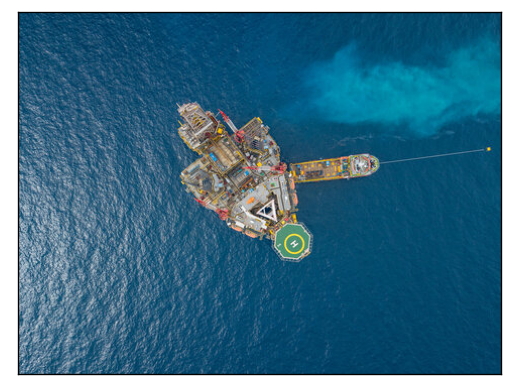

In [2]:
img = iio.imread('im04.jpg')

def scale(img):
    return np.uint8((img-np.min(img))/(np.max(img)-np.min(img))*255)

def show_image(img, title='', save=False, name='', ticks=True):
    '''
    a function for showing images
    '''
    plt.figure(dpi=120)
    plt.imshow(img, cmap='gray')
    if ticks:
        plt.xticks([])
        plt.yticks([])
    plt.title(title)
    if save:
        iio.imwrite(name, img)
    plt.show()
show_image(img)

## Starting Points

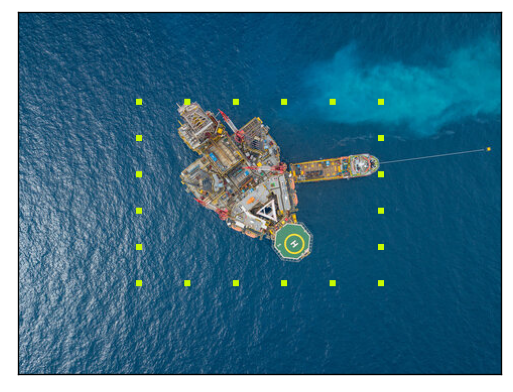

In [3]:
def starting_points(img):
    x, y, c = img.shape
    points = [(0, 0)]*20
    points[0] = (int(x//4), int(y//4))
    points[5] = (int((3*x)//4), int(y//4))
    points[10] = (int((3*x)//4), int((3*y)//4))
    points[15] = (int(x//4), int((3*y)//4))
    for i in range(4):
        points[i+1] = (int(x//4+(i+1)*(1*x//10)), int(y//4))
    for i in range(4):
        points[i+16] = (int(x//4), int(3*y//4-(i+1)*(1*y//10)))
    for i in range(4):
        points[i+11] = (int(3*x//4), int(y//4+(i+1)*(1*y//10)))
    for i in range(4):
        points[i+6] = (int(x//4+(i+1)*(1*x//10)), int(3*y//4))
        
    out = img.copy()
    for p in points:
        out[p[0]-3:p[0]+3, p[1]-3:p[1]+3, 0] = 200
        out[p[0]-3:p[0]+3, p[1]-3:p[1]+3, 1] = 250
        out[p[0]-3:p[0]+3, p[1]-3:p[1]+3, 2] = 0
    show_image(out)
    return points
    
points = starting_points(img)

## Cost Function

In [13]:
def E_int(points, alpha):
    points = np.array(points.copy())
    shifted_points = np.roll(points, 1, axis=0)
    d = np.mean(np.sum((points-shifted_points)**2))
    E = np.sum(((points-shifted_points)[:,0]**2+(points-shifted_points)[:,1]**2-alpha*d)**2)
    return E

def E_ext(img, points):
    E = 0
    grad = img[:,:,0].copy()
    gradx = ndimage.sobel(grad, axis=0, mode='constant')
    grady = ndimage.sobel(grad, axis=1, mode='constant')
    gradx = np.float32(gradx)
    grady = np.float32(grady)
    for p in points:
        E -= (gradx[p[0], p[1]]**2 + grady[p[0], p[1]]**2)
    return np.sum(E)

def cost(img, points, alpha=50, gamma=10**5):
    return E_int(points, alpha) + gamma * E_ext(img, points)

## Active Contours

In [19]:
def neighbors(img, p):
    x, y = p[0], p[1]
    nei = [(x-1,y),(x+1,y),(x-1,y-1),(x-1,y+1),(x,y+1),(x,y-1),(x+1,y-1),(x+1,y+1)]
    return nei

def draw_points(img, points, name):
    out = img.copy()
    for p in points:
        out[p[0]-3:p[0]+3, p[1]-3:p[1]+3, 0] = 150
        out[p[0]-3:p[0]+3, p[1]-3:p[1]+3, 1] = 200
        out[p[0]-3:p[0]+3, p[1]-3:p[1]+3, 2] = 150
    iio.imwrite(name, out)
    return out

def active_contour(img, points, alpha=2.3e3, gamma=5*10**9):
    for cnt in range(100):
        for i,p in enumerate(points):
            c = 10**20
            for nei in neighbors(img, p):
                new_points = points.copy()
                new_points[i] = nei
                c_new = cost(img, new_points, alpha, gamma)
                if c_new < c:
                    c = c_new
                    points = new_points.copy()
        name = f'images/{cnt}.png'
        draw_points(img, points, name)   
        
active_contour(img, points)
os.system('ffmpeg -start_number 0 -i images/%d.png -r 100 -vcodec mpeg4 res13-contour.mp4')

0